In [ ]:
import os, glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
 
fit_path = "/home/riku/projects/athlet_hr_predict/fit_file_csv"
os.chdir(fit_path)

In [ ]:

n_X = 60 # number of timesteps for training
n_y = 30 # number of timesteps to predict
step = 1
batch_size = 10
epochs = 50
learning_rate = 0.001
sequence_length = int(n_X/step)
n_fit_files_test_set = 1 # number of files for testing dataset

train_files = glob.glob("*.csv")[0:-n_fit_files_test_set]
valid_files = glob.glob("*.csv")[-n_fit_files_test_set:]

In [ ]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    #return (data - data_mean) / data_std, data_mean, data_std
    return data_mean, data_std

li = []

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]]
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df_mean, df_std = normalize(df)

In [ ]:
# validation dataset - train each file at the time

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]]
    df = (df - df_mean) / df_std
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]].values
    y = df.iloc[n_X:end][["heart_rate"]]
    
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )

In [ ]:
for batch in dataset_val.take(1):
    inputs, targets = batch

In [ ]:


# the model
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(4)(inputs)
#lstm_out = keras.layers.LSTM(4)(lstm_out)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


In [ ]:
# training dataset, and train each file at the time

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]]
    df = (df - df_mean) / df_std
    print(file)
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[["heart_rate", "cadence","enhanced_speed","enhanced_altitude"]].values
    y = df.iloc[n_X:end][["heart_rate"]]
    
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )
    
    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_val,
        callbacks=[es_callback, modelckpt_callback],
        verbose=0
    )

    


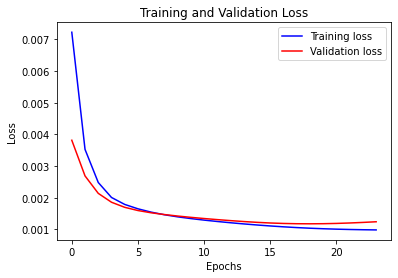

In [8]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")